In [1]:
!pip install tf-nightly-gpu-2.0-preview
import tensorflow as tf

  Preparing metadata (setup.py) ... done
  Created wheel for tf-nightly-gpu-2.0-preview: filename=tf_nightly_gpu_2_0_preview-0.0.0.1-py3-none-any.whl size=1542 sha256=7cfa53c584109be4ea55e64bf0f929aa93eb59428a14eac954a378f182359dd6
  Stored in directory: /root/.cache/pip/wheels/89/c6/2e/5b35865ca6234c39a564b7803e8105a8050cb66121a475b27c
Successfully built tf-nightly-gpu-2.0-preview


In [2]:
device_name=tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# **Xception model**

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.utils import image_dataset_from_directory
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
# Ensure TensorFlow is using GPU

if tf.config.list_physical_devices('GPU'):
    print("✅ GPU is available and being used.")
else:
    print("❌ No GPU found. Check Kaggle settings.")

✅ GPU is available and being used.


Class Distribution Before Oversampling:
DRUSEN: 8616 images
CNV: 37205 images
NORMAL: 51140 images
DME: 11348 images


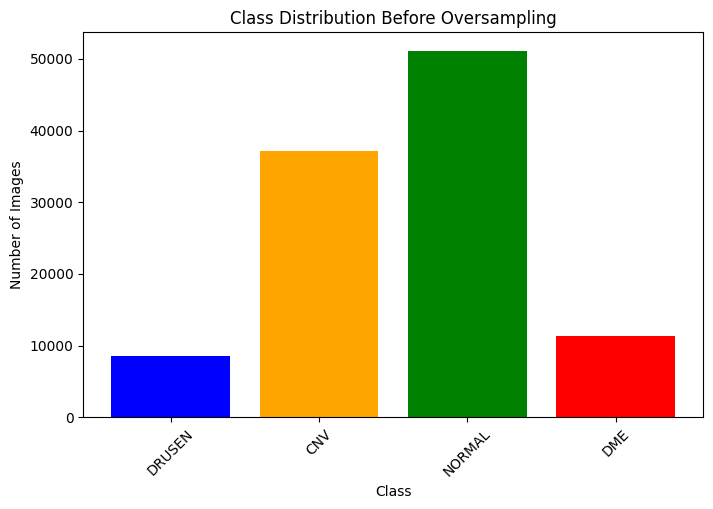

In [5]:
# -------------------------------
# Count Images in Each Class (Before Training)
# -------------------------------
import os 

def count_images_in_classes(dataset_path):
    class_counts = {}
    for class_name in os.listdir(dataset_path):  
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

dataset_path = "/kaggle/input/eye-disease-detection/Project Exhibition 2 Dataset/train"
class_counts_before = count_images_in_classes(dataset_path)

print("Class Distribution Before Oversampling:")
for class_name, count in class_counts_before.items():
    print(f"{class_name}: {count} images")

# Plot class distribution before oversampling
plt.figure(figsize=(8, 5))
plt.bar(class_counts_before.keys(), class_counts_before.values(), color=['blue', 'orange', 'green', 'red'])
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution Before Oversampling")
plt.xticks(rotation=45)
plt.show()

In [5]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load the training set (76,000 images)
training_set = image_dataset_from_directory(
    "/kaggle/input/eye-disease-detection/Project Exhibition 2 Dataset/train",  # Use the original dataset folder
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(299,299),
    shuffle=True,
    seed=42,
    validation_split=1 - (76000 / 108309),  # The remaining images will go to validation
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

# Load the validation set (remaining images)
validation_set = image_dataset_from_directory(
    "/kaggle/input/eye-disease-detection/Project Exhibition 2 Dataset/train",  # Same dataset directory
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(299,299),
    shuffle=True,
    seed=42,
    validation_split=1 - (76000 / 108309),  # Same split ratio
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

print("Train dataset size:", training_set.cardinality().numpy() * 32)
print("Validation dataset size:", validation_set.cardinality().numpy() * 32)


Found 108309 files belonging to 4 classes.
Using 76000 files for training.
Found 108309 files belonging to 4 classes.
Using 32309 files for validation.
Train dataset size: 76000
Validation dataset size: 32320


In [6]:
INPUT_SHAPE=(299, 299,3)

In [8]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

xception = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=INPUT_SHAPE,
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)
xception.trainable = False 

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
# Add custom classification layers
x = GlobalAveragePooling2D()(xception.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(4, activation="softmax")(x)  # 4 classes (CNV, DME, DRUSEN, NORMAL)

In [10]:
# Create final model
model = Model(inputs=xception.input, outputs=x)

In [11]:
metrics_list=["accuracy", tf.keras.metrics.F1Score()]

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=metrics_list)

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 21,912,620 (83.59 MB)

 Trainable params: 1,051,140 (4.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [14]:
training_history=model.fit(x=training_set, validation_data=validation_set, epochs=15)

Epoch 1/15
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 858s 351ms/step - accuracy: 0.5760 - f1_score: 0.3707 - loss: 1.5743 - val_accuracy: 0.7113 - val_f1_score: 0.4298 - val_loss: 0.7875
Epoch 2/15
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 820s 345ms/step - accuracy: 0.7015 - f1_score: 0.4543 - loss: 0.8103 - val_accuracy: 0.7378 - val_f1_score: 0.4942 - val_loss: 0.7194
Epoch 3/15
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 819s 345ms/step - accuracy: 0.7225 - f1_score: 0.4929 - loss: 0.7492 - val_accuracy: 0.7486 - val_f1_score: 0.4932 - val_loss: 0.6851
Epoch 4/15
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 818s 345ms/step - accuracy: 0.7378 - f1_score: 0.5168 - loss: 0.7119 - val_accuracy: 0.7543 - val_f1_score: 0.5195 - val_loss: 0.6660
Epoch 5/15
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 818s 344ms/step - accuracy: 0.7453 - f1_score: 0.5359 - loss: 0.6894 - val_accuracy: 0.7643 - val_f1_score: 0.5502 - val_loss: 0.6531
Epoch 6/15
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 818s 345ms/step - accuracy: 0.7539 - f1_score: 0.5544 - loss: 0.6699 - val_acc

In [15]:
model.save("xception_model.h5")
model.save("xception_model.keras")

In [ ]:
import pickle

# Save the training history (history.history is a dict with loss/accuracy values per epoch)
with open("xception_Training_history.pkl", "wb") as file:
    pickle.dump(training_history.history, file)

# **Fine Tuning**

In [7]:
from tensorflow.keras.models import load_model

model = load_model("/kaggle/input/xception/other/default/1/xception_model.h5")  # Load saved model

In [8]:
# Unfreeze last 30 layers for fine-tuning
for layer in model.layers[-30:]:
    layer.trainable = True

In [9]:
metrics_list=["accuracy", tf.keras.metrics.F1Score()]

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss="categorical_crossentropy", metrics=metrics_list)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

In [12]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7)

In [13]:
# Train with data augmentation and fine-tuning
history_fine_tune = model.fit(x=training_set, validation_data=validation_set, epochs=3,callbacks=[early_stopping, reduce_lr])

Epoch 1/3
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 1171s 476ms/step - accuracy: 0.6541 - f1_score: 0.3825 - loss: 0.9076 - val_accuracy: 0.8232 - val_f1_score: 0.6365 - val_loss: 0.4950 - learning_rate: 1.0000e-05
Epoch 2/3
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 1115s 470ms/step - accuracy: 0.8221 - f1_score: 0.6424 - loss: 0.5036 - val_accuracy: 0.8432 - val_f1_score: 0.6982 - val_loss: 0.4401 - learning_rate: 1.0000e-05
Epoch 3/3
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 1114s 469ms/step - accuracy: 0.8525 - f1_score: 0.7197 - loss: 0.4151 - val_accuracy: 0.8672 - val_f1_score: 0.6966 - val_loss: 0.3681 - learning_rate: 1.0000e-05


In [14]:
model.save("xception_model_fine_tune.h5")
model.save("xception_model_fine_tune.keras")

In [15]:
import pickle

# Save the training history (history.history is a dict with loss/accuracy values per epoch)
with open("xception_Training_history_fine_tune.pkl", "wb") as file:
    pickle.dump(history_fine_tune.history, file)

In [18]:
# Train with data augmentation and fine-tuning
history_fine_tune_1 = model.fit(x=training_set, validation_data=validation_set, epochs=3,callbacks=[early_stopping, reduce_lr])

Epoch 1/3
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 1113s 468ms/step - accuracy: 0.8714 - f1_score: 0.7625 - loss: 0.3682 - val_accuracy: 0.8703 - val_f1_score: 0.7510 - val_loss: 0.3719 - learning_rate: 1.0000e-05
Epoch 2/3
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 1115s 470ms/step - accuracy: 0.8821 - f1_score: 0.7834 - loss: 0.3355 - val_accuracy: 0.8705 - val_f1_score: 0.7482 - val_loss: 0.3768 - learning_rate: 1.0000e-05
Epoch 3/3
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 1115s 469ms/step - accuracy: 0.8930 - f1_score: 0.8068 - loss: 0.3067 - val_accuracy: 0.8966 - val_f1_score: 0.8083 - val_loss: 0.2967 - learning_rate: 1.0000e-05


In [20]:
model.save("xception1_model_fine_tune.h5")
model.save("xception1_model_fine_tune.keras")

In [21]:
import pickle

# Save the training history (history.history is a dict with loss/accuracy values per epoch)
with open("xception1_Training_history_fine_tune.pkl", "wb") as file:
    pickle.dump(history_fine_tune_1.history, file)

In [7]:
from tensorflow.keras.models import load_model

model = load_model("/kaggle/input/xception-fine-tuned/other/default/1/xception1_model_fine_tune.h5")  # Load saved model

In [8]:
# Unfreeze last 30 layers for fine-tuning
for layer in model.layers[-30:]:
    layer.trainable = True

In [9]:
metrics_list=["accuracy", tf.keras.metrics.F1Score()]

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss="categorical_crossentropy", metrics=metrics_list)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7)

In [15]:
# Train with data augmentation and fine-tuning
history_fine_tune_final = model.fit(x=training_set, validation_data=validation_set, epochs=4,callbacks=[early_stopping, reduce_lr])

Epoch 1/4
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 1012s 409ms/step - accuracy: 0.9013 - f1_score: 0.8237 - loss: 0.2867 - val_accuracy: 0.8757 - val_f1_score: 0.7648 - val_loss: 0.3724 - learning_rate: 1.0000e-05
Epoch 2/4
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 948s 399ms/step - accuracy: 0.9080 - f1_score: 0.8351 - loss: 0.2685 - val_accuracy: 0.8960 - val_f1_score: 0.8115 - val_loss: 0.3031 - learning_rate: 1.0000e-05
Epoch 3/4
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 948s 399ms/step - accuracy: 0.9146 - f1_score: 0.8483 - loss: 0.2502 - val_accuracy: 0.8979 - val_f1_score: 0.7711 - val_loss: 0.2884 - learning_rate: 1.0000e-05
Epoch 4/4
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 949s 400ms/step - accuracy: 0.9179 - f1_score: 0.8545 - loss: 0.2364 - val_accuracy: 0.8999 - val_f1_score: 0.8129 - val_loss: 0.2996 - learning_rate: 1.0000e-05


In [16]:
model.save("xception_model_fine_final_tune.h5")
model.save("xception_model_fine_tune_final.keras")

In [18]:
import pickle

# Save the training history (history.history is a dict with loss/accuracy values per epoch)
with open("xception_Training_history_fine_tune_final.pkl", "wb") as file:
    pickle.dump(history_fine_tune_final.history, file)

# **Model performance**

In [19]:
#REloading history from pickle file
import pickle
with open("xception_Training_history_fine_tune_final.pkl", "rb") as f:
    load_history=pickle.load(f)
print(load_history)

{'accuracy': [0.9023157954216003, 0.9090657830238342, 0.9150921106338501, 0.9198157787322998], 'f1_score': [<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9317256 , 0.8009995 , 0.6181578 , 0.94338024], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.93717885, 0.8129731 , 0.64657176, 0.94745445], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.94244105, 0.8244184 , 0.67473185, 0.95029473], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.94574636, 0.84157246, 0.68543315, 0.9528768 ], dtype=float32)>], 'loss': [0.2813261151313782, 0.2638019025325775, 0.24671296775341034, 0.23276084661483765], 'val_accuracy': [0.8757002949714661, 0.895973265171051, 0.8978613018989563, 0.8998730778694153], 'val_f1_score': [<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.926979 , 0.723026 , 0.4977519, 0.9114925], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.927642  , 0.77429265, 0.60611665, 0.93808585]

In [20]:
load_history.keys()

dict_keys(['accuracy', 'f1_score', 'loss', 'val_accuracy', 'val_f1_score', 'val_loss', 'learning_rate'])

# **Model Evaluation**

In [22]:
#pre-processing the test dataset
test_set = image_dataset_from_directory(
    "/kaggle/input/eye-disease-detection/Project Exhibition 2 Dataset/test",  # Same dataset directory
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(299, 299),
    shuffle=False,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 1000 files belonging to 4 classes.


In [23]:
test_loss, test_acc, f1_score=model.evaluate(test_set)

32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 463ms/step - accuracy: 0.8567 - f1_score: 0.4891 - loss: 0.4715


In [24]:
test_loss, test_acc, f1_score

(0.8314151763916016,
 0.7419999837875366,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.727802  , 0.93528175, 0.17518248, 0.87142855], dtype=float32)>)

In [25]:
true_categories=tf.concat([y for x, y in test_set], axis=0)
Y_true=tf.argmax(true_categories, axis=1)

In [26]:
#computing predicted labels using test_set
predicted_categories = model.predict(test_set)

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 285ms/step


In [27]:
Y_Pred=tf.argmax(predicted_categories, axis=1)
Y_Pred

<tf.Tensor: shape=(1000,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3,
    

# **Classification Report**

In [28]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_Pred))

              precision    recall  f1-score   support

           0       0.57      1.00      0.73       250
           1       0.98      0.90      0.94       250
           2       1.00      0.10      0.18       250
           3       0.79      0.98      0.87       250

    accuracy                           0.74      1000
   macro avg       0.83      0.74      0.68      1000
weighted avg       0.83      0.74      0.68      1000



# **Confusion Matrix**

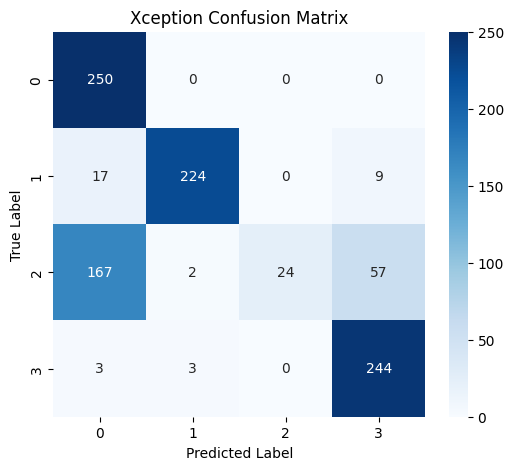

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm=confusion_matrix(Y_true, Y_Pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Xception Confusion Matrix", fontsize=12)
plt.show()

# **Single Prediction Code**

In [30]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
import numpy as np
import os

In [ ]:
image_path = "/kaggle/input/eye-disease-detection/Project Exhibition 2 Dataset/test/DRUSEN/DRUSEN-11129-2.jpeg"
img = tf.keras.utils.load_img(image_path, target_size=(299,299))
img

In [34]:
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [35]:
x.shape

(1, 299, 299, 3)

In [36]:
pred = model.predict(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [37]:
class_name=['CNV', 'DME', 'DRUSEN', 'NORMAL']
result_index = np.argmax(pred)
print("Model Prediction: ", class_name[result_index])

Model Prediction:  CNV
